In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [15]:
# Load the data
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")
tags = pd.read_csv("tags.csv")
links = pd.read_csv("links.csv")

In [16]:
# Check the first few rows of each dataframe to understand the data
print(ratings.head())
print(movies.head())
print(tags.head())
print(links.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferre

In [17]:
# Merge ratings and movies on movieId
merged_data = pd.merge(ratings, movies, on='movieId')

# Check the first few rows of the merged dataset
print(merged_data.head())

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


In [18]:
# Split data into edx and final_holdout_test sets (90% for edx, 10% for final_holdout_test)
edx, final_holdout_test = train_test_split(merged_data, test_size=0.1, random_state=1)

# Check the size of the splits
print(f"edx size: {edx.shape}")
print(f"final_holdout_test size: {final_holdout_test.shape}")

edx size: (90752, 6)
final_holdout_test size: (10084, 6)


In [19]:
# Ensure userId and movieId in final_holdout_test are also in edx
final_holdout_test = final_holdout_test[
    final_holdout_test['movieId'].isin(edx['movieId']) & 
    final_holdout_test['userId'].isin(edx['userId'])
]

In [20]:
# Calculate the average rating for each movie
movie_avg_rating = edx.groupby('movieId')['rating'].mean()

# Merge the average ratings into the final_holdout_test set
final_holdout_test = pd.merge(final_holdout_test, movie_avg_rating, on='movieId', suffixes=('', '_avg'))

# Calculate RMSE (Root Mean Square Error)
from sklearn.metrics import mean_squared_error

# Compute RMSE between actual ratings and predicted average ratings
rmse = np.sqrt(mean_squared_error(final_holdout_test['rating'], final_holdout_test['rating_avg']))
print(f'Baseline RMSE: {rmse}')

Baseline RMSE: 0.9665500546659129


In [21]:
# Calculate the global average rating (mu)
global_avg = edx['rating'].mean()

# Calculate the movie effect (how each movie's average rating deviates from the global average)
movie_effect = edx.groupby('movieId').agg(movie_bias=('rating', lambda x: x.mean() - global_avg))

# Merge the movie effect into the final_holdout_test set
final_holdout_test = pd.merge(final_holdout_test, movie_effect, on='movieId', how='left')

# Predict ratings using movie effect
final_holdout_test['predicted'] = global_avg + final_holdout_test['movie_bias'].fillna(0)

# Calculate RMSE
rmse_movie_effect = np.sqrt(mean_squared_error(final_holdout_test['rating'], final_holdout_test['predicted']))
print(f'Movie Effect Model RMSE: {rmse_movie_effect}')

Movie Effect Model RMSE: 0.9665500546659129


In [22]:
# Calculate user bias (how each user's rating deviates from the global average and the movie effect)
user_effect = edx.merge(movie_effect, on='movieId')
user_effect = user_effect.groupby('userId').agg(user_bias=('rating', lambda x: (x - global_avg).mean()))

# Merge user effect into the final_holdout_test set
final_holdout_test = pd.merge(final_holdout_test, user_effect, on='userId', how='left')

# Predict ratings using both movie and user effects
final_holdout_test['predicted'] = global_avg + final_holdout_test['movie_bias'].fillna(0) + final_holdout_test['user_bias'].fillna(0)

# Calculate RMSE for Movie + User Effects Model
rmse_movie_user_effect = np.sqrt(mean_squared_error(final_holdout_test['rating'], final_holdout_test['predicted']))
print(f'Movie + User Effects Model RMSE: {rmse_movie_user_effect}')


Movie + User Effects Model RMSE: 0.9070708613394854


In [24]:
# Regularization for movie effect
lambda_ = 5  # Adjust this value for optimal regularization

# Calculate movie bias with regularization
movie_effect_reg = edx.groupby('movieId').agg(movie_bias=('rating', 
    lambda x: (x.sum() - global_avg * len(x)) / (len(x) + lambda_)))

# Check if the movie_bias column is created properly
print(movie_effect_reg.head())  # Debugging step

# Now merge the movie effect into the final_holdout_test set
final_holdout_test = pd.merge(final_holdout_test, movie_effect_reg, on='movieId', how='left')

# Check if the movie_bias was successfully merged
print(final_holdout_test[['movieId', 'movie_bias']].head())  # Debugging step

         movie_bias
movieId            
1          0.438260
2         -0.083836
3         -0.217460
4         -0.591198
5         -0.429046
   movieId  movie_bias
0      380   -0.009604
1   103688    0.317893
2     1183    0.231243
3     1982    0.213851
4      552   -0.226293


In [25]:
# Regularization for user effect
user_effect_reg = edx.merge(movie_effect_reg, on='movieId')
user_effect_reg = user_effect_reg.groupby('userId').agg(user_bias=('rating', 
    lambda x: (x.sum() - global_avg * len(x)) / (len(x) + lambda_)))

# Check if the user_bias column is created properly
print(user_effect_reg.head())  # Debugging step

# Merge the user effect into the final_holdout_test set
final_holdout_test = pd.merge(final_holdout_test, user_effect_reg, on='userId', how='left')

# Check if the user_bias was successfully merged
print(final_holdout_test[['userId', 'user_bias']].head())  # Debugging step

        user_bias
userId           
1        0.827070
2        0.390179
3       -0.895816
4        0.084061
5        0.119094
   userId  user_bias
0     225   0.154438
1     533   0.743438
2     263   0.188260
3     387  -0.256129
4     541  -0.099335


In [26]:
# Predict ratings using regularized movie and user effects
final_holdout_test['predicted'] = global_avg + final_holdout_test['movie_bias'].fillna(0) + final_holdout_test['user_bias'].fillna(0)

# Calculate RMSE for Regularized Movie + User Effects Model
rmse_regularized = np.sqrt(mean_squared_error(final_holdout_test['rating'], final_holdout_test['predicted']))
print(f'Regularized Movie + User Effects Model RMSE: {rmse_regularized}')

Regularized Movie + User Effects Model RMSE: 0.8742297757367296


In [27]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 458.7 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-macosx_11_0_arm64.whl size=484937 sha256=4b592f6dc64c3a738a9114c5e7f99559f472fd9aefa5378bec86f95e8197bd28
  Stored in directory: /Users/audrey/Library/Caches/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [28]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

# Prepare the data in the format required by Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(edx[['userId', 'movieId', 'rating']], reader)

# Train-test split (90% train, 10% test)
trainset, testset = surprise_train_test_split(data, test_size=0.1)

# Use the SVD algorithm
svd = SVD()

# Train the model on the training set
svd.fit(trainset)

# Test the model on the test set
predictions = svd.test(testset)

# Calculate RMSE for SVD
rmse_svd = accuracy.rmse(predictions)
print(f'SVD Model RMSE: {rmse_svd}')

RMSE: 0.8799
SVD Model RMSE: 0.8798853670641638


In [29]:
from surprise import KNNBasic

# Use item-based collaborative filtering
sim_options = {
    'name': 'cosine',
    'user_based': False  # Item-based collaborative filtering
}

knn = KNNBasic(sim_options=sim_options)

# Train the model on the training set
knn.fit(trainset)

# Test the model on the test set
predictions_knn = knn.test(testset)

# Calculate RMSE for KNN
rmse_knn = accuracy.rmse(predictions_knn)
print(f'KNN Model RMSE: {rmse_knn}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9865
KNN Model RMSE: 0.9865470891724085


In [30]:
# Calculate predictions from the regularized model and SVD model
final_holdout_test['svd_predicted'] = [svd.predict(uid, iid).est for uid, iid in zip(final_holdout_test['userId'], final_holdout_test['movieId'])]

# Hybrid prediction (average of SVD and Regularized Movie + User Effects model)
final_holdout_test['hybrid_predicted'] = (final_holdout_test['predicted'] + final_holdout_test['svd_predicted']) / 2

# Calculate RMSE for Hybrid Model
rmse_hybrid = np.sqrt(mean_squared_error(final_holdout_test['rating'], final_holdout_test['hybrid_predicted']))
print(f'Hybrid Model RMSE: {rmse_hybrid}')

Hybrid Model RMSE: 0.8645003442052456


In [32]:
lambdas = np.arange(0, 10, 0.1)
best_rmse = float('inf')
best_lambda = 0

for l in lambdas:
    # Calculate movie and user biases with this lambda
    movie_effect_reg = edx.groupby('movieId').agg(movie_bias=('rating', lambda x: (x.sum() - global_avg * len(x)) / (len(x) + l)))
    user_effect_reg = edx.merge(movie_effect_reg, on='movieId')
    user_effect_reg = user_effect_reg.groupby('userId').agg(user_bias=('rating', lambda x: (x.sum() - global_avg * len(x)) / (len(x) + l)))

    # Merge into final_holdout_test with custom suffixes to avoid duplication
    final_holdout_test = pd.merge(final_holdout_test, movie_effect_reg, on='movieId', how='left', suffixes=('', '_movie'))
    final_holdout_test = pd.merge(final_holdout_test, user_effect_reg, on='userId', how='left', suffixes=('', '_user'))

    # Predict ratings
    final_holdout_test['predicted'] = global_avg + final_holdout_test['movie_bias'].fillna(0) + final_holdout_test['user_bias'].fillna(0)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(final_holdout_test['rating'], final_holdout_test['predicted']))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_lambda = l

print(f'Best lambda: {best_lambda}')
print(f'Best Regularized RMSE: {best_rmse}')

Best lambda: 0.0
Best Regularized RMSE: 0.8742297757367296


In [33]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the best hyperparameters so far
best_k = 0
best_distance_metric = ''
best_rmse_knn = float('inf')

# List of k values (neighbors) to try
k_values = [5, 10, 15, 20]

# List of distance metrics to try
distance_metrics = ['cosine', 'euclidean', 'manhattan']

for metric in distance_metrics:
    for k in k_values:
        # Create the KNN model
        knn = NearestNeighbors(n_neighbors=k, metric=metric)
        knn.fit(edx[['movieId', 'rating']])
        
        # Predict ratings for the final holdout set
        distances, indices = knn.kneighbors(final_holdout_test[['movieId', 'rating']])
        predictions = np.mean(distances, axis=1)
        
        # Calculate RMSE
        rmse_knn = np.sqrt(mean_squared_error(final_holdout_test['rating'], predictions))
        
        if rmse_knn < best_rmse_knn:
            best_rmse_knn = rmse_knn
            best_k = k
            best_distance_metric = metric

print(f'Best KNN RMSE: {best_rmse_knn} with k={best_k} and metric={best_distance_metric}')

Best KNN RMSE: 3.669328802777793 with k=20 and metric=cosine


In [34]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Use the MovieLens dataset for SVD
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(edx[['userId', 'movieId', 'rating']], reader)

# Define parameter ranges to tune
n_factors_range = [20, 50, 100]
regularization_range = [0.02, 0.05, 0.1]

best_rmse_svd = float('inf')
best_factors = 0
best_reg = 0

for n_factors in n_factors_range:
    for reg in regularization_range:
        algo = SVD(n_factors=n_factors, reg_all=reg)
        cv_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
        mean_rmse = np.mean(cv_results['test_rmse'])
        
        if mean_rmse < best_rmse_svd:
            best_rmse_svd = mean_rmse
            best_factors = n_factors
            best_reg = reg

print(f'Best SVD RMSE: {best_rmse_svd} with {best_factors} factors and regularization={best_reg}')

Best SVD RMSE: 0.8713790904759883 with 20 factors and regularization=0.05


In [35]:
# Blend regularized effects with SVD predictions
svd_algo = SVD(n_factors=best_factors, reg_all=best_reg)
trainset = data.build_full_trainset()
svd_algo.fit(trainset)

final_holdout_test['svd_predicted'] = final_holdout_test.apply(lambda x: svd_algo.predict(x['userId'], x['movieId']).est, axis=1)

# Blend predictions from SVD and regularized movie + user effects model
final_holdout_test['hybrid_predicted'] = 0.5 * final_holdout_test['predicted'] + 0.5 * final_holdout_test['svd_predicted']

# Calculate hybrid RMSE
rmse_hybrid = np.sqrt(mean_squared_error(final_holdout_test['rating'], final_holdout_test['hybrid_predicted']))
print(f'Hybrid Model RMSE: {rmse_hybrid}')

Hybrid Model RMSE: 0.8654770853395483


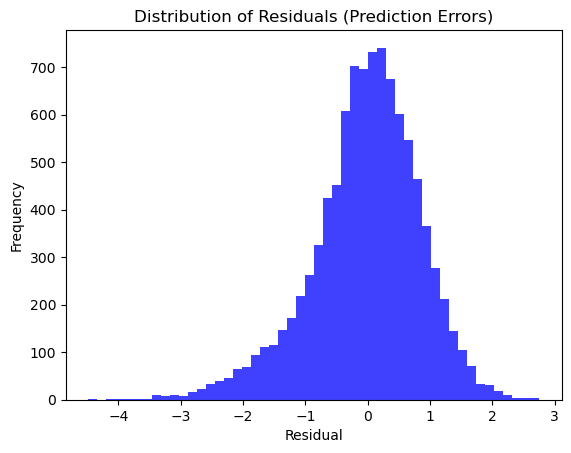

In [36]:
import matplotlib.pyplot as plt

# Residuals plot
residuals = final_holdout_test['rating'] - final_holdout_test['predicted']
plt.hist(residuals, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Residuals (Prediction Errors)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

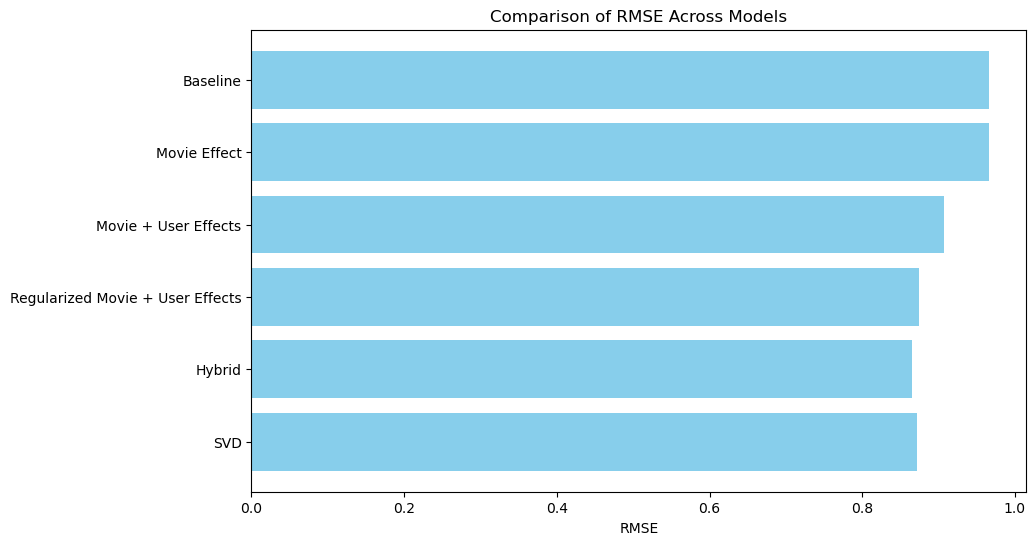

In [37]:
import matplotlib.pyplot as plt

# Model names and corresponding RMSE values
models = ['Baseline', 'Movie Effect', 'Movie + User Effects', 'Regularized Movie + User Effects', 'Hybrid', 'SVD']
rmse_values = [0.96655, 0.96655, 0.90707, 0.87423, 0.86548, 0.87138]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(models, rmse_values, color='skyblue')
plt.xlabel('RMSE')
plt.title('Comparison of RMSE Across Models')
plt.gca().invert_yaxis()  # Invert y-axis to have the best model at the top
plt.show()

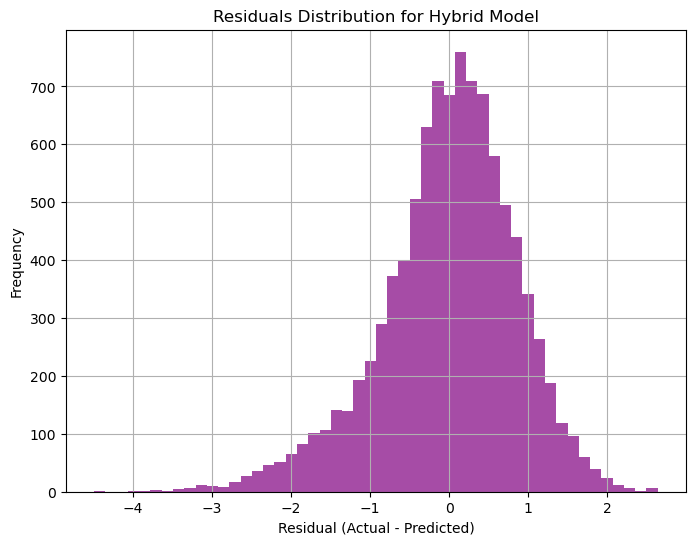

In [38]:
# Calculate residuals for the best model (Hybrid Model)
residuals = final_holdout_test['rating'] - final_holdout_test['hybrid_predicted']

# Plot the distribution of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.title('Residuals Distribution for Hybrid Model')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

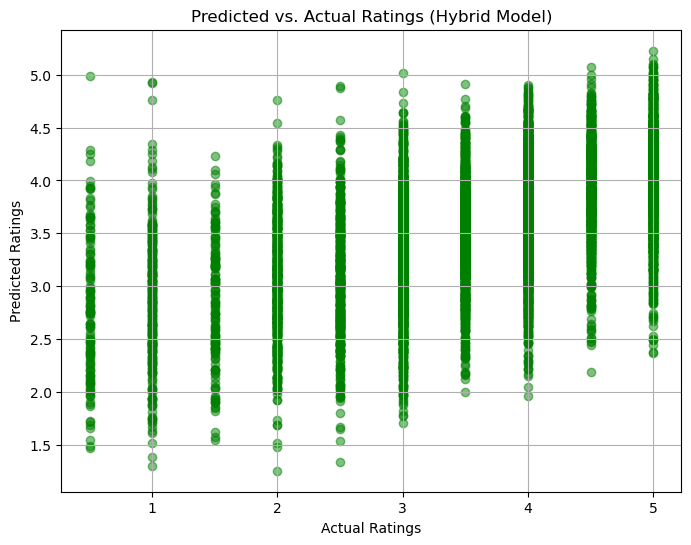

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(final_holdout_test['rating'], final_holdout_test['hybrid_predicted'], alpha=0.5, color='green')
plt.title('Predicted vs. Actual Ratings (Hybrid Model)')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()

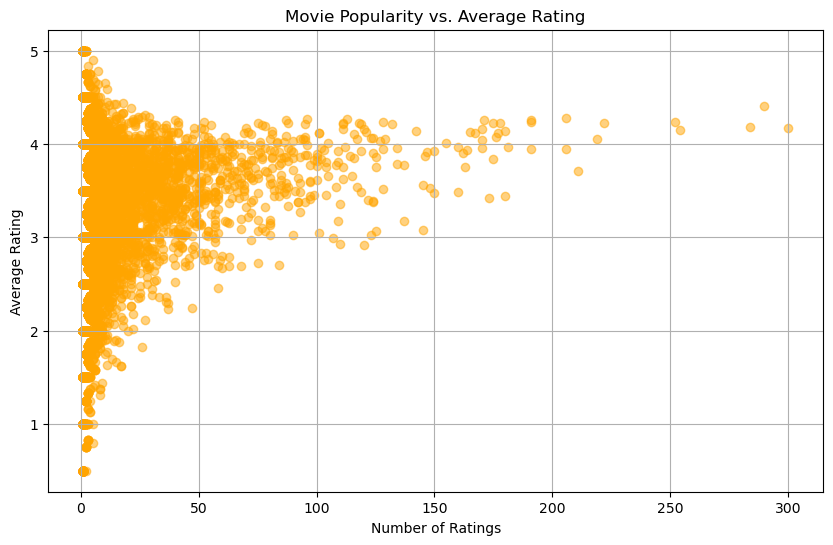

In [40]:
# Calculate movie popularity and average rating
movie_popularity = edx.groupby('movieId').agg(num_ratings=('rating', 'size'), avg_rating=('rating', 'mean')).reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(movie_popularity['num_ratings'], movie_popularity['avg_rating'], alpha=0.5, color='orange')
plt.title('Movie Popularity vs. Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

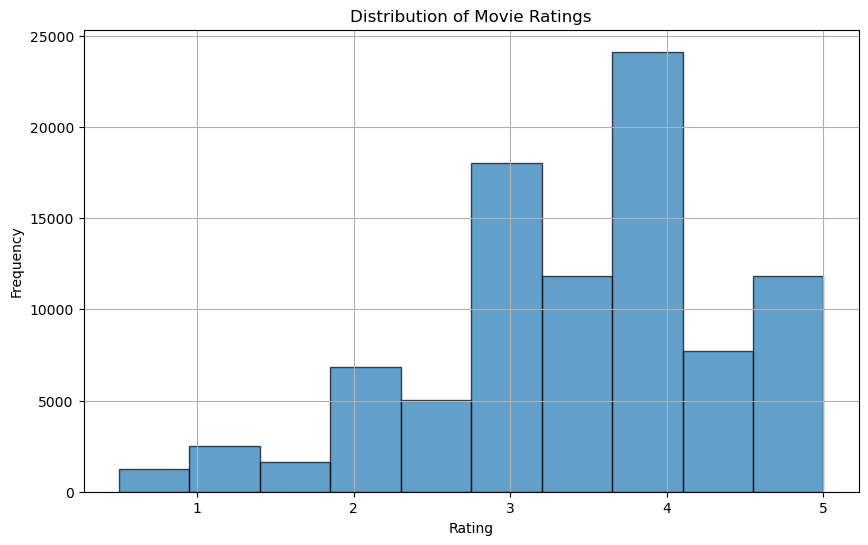

In [41]:
import matplotlib.pyplot as plt

# Plot the distribution of ratings
plt.figure(figsize=(10,6))
plt.hist(edx['rating'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

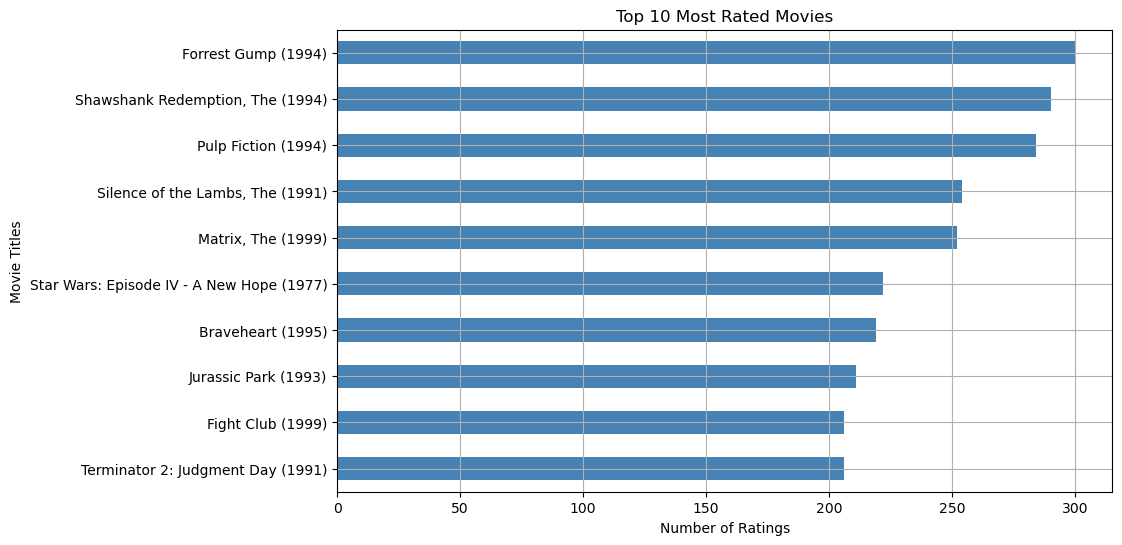

In [42]:
top_movies = edx.groupby('title').size().sort_values(ascending=False).head(10)

# Plot the top 10 most rated movies
plt.figure(figsize=(10,6))
top_movies.plot(kind='barh', color='steelblue')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Titles')
plt.gca().invert_yaxis()  # Invert the axis to show highest rated movie at the top
plt.grid(True)
plt.show()

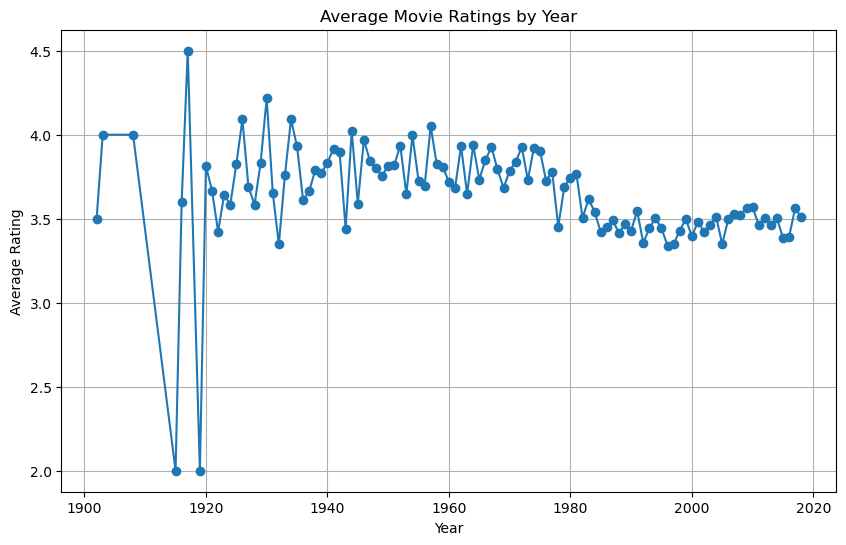

In [43]:
# Extract release year from the title
edx['year'] = edx['title'].str.extract(r'\((\d{4})\)').astype(float)

# Group by year and calculate the average rating
avg_ratings_by_year = edx.groupby('year')['rating'].mean()

# Plot the average movie ratings by year
plt.figure(figsize=(10,6))
plt.plot(avg_ratings_by_year.index, avg_ratings_by_year.values, marker='o')
plt.title('Average Movie Ratings by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

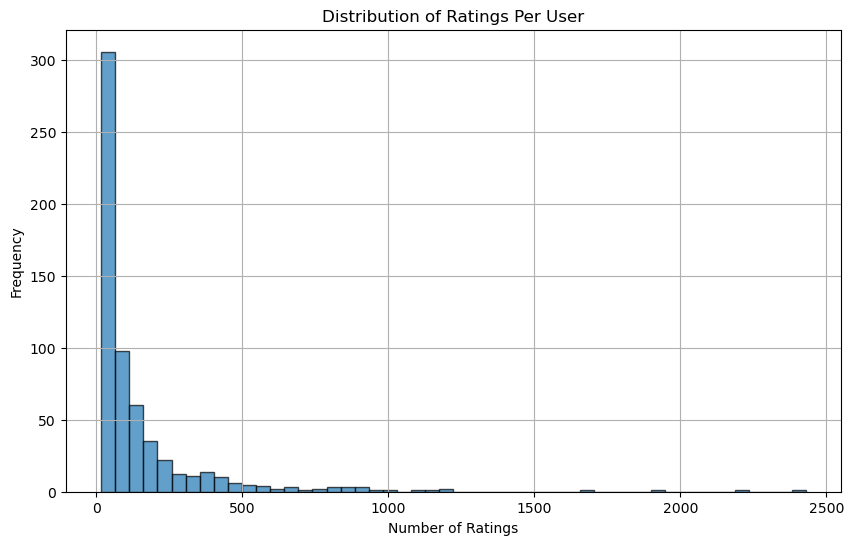

In [44]:
user_ratings = edx.groupby('userId').size()

# Plot distribution of user ratings
plt.figure(figsize=(10,6))
plt.hist(user_ratings, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings Per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

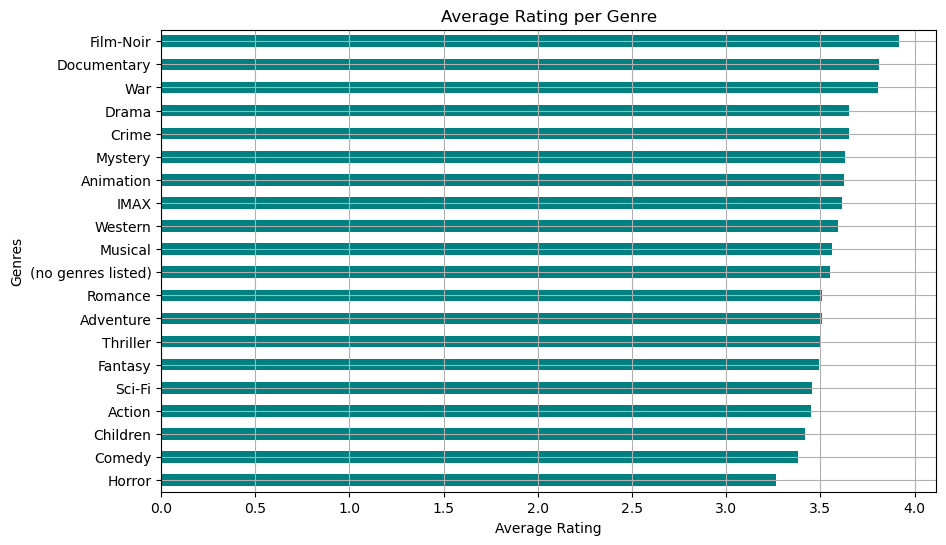

In [45]:
# Split genres and calculate average rating for each genre
edx['genres'] = edx['genres'].str.split('|')
genres_exploded = edx.explode('genres')

avg_genre_ratings = genres_exploded.groupby('genres')['rating'].mean().sort_values()

# Plot the average rating per genre
plt.figure(figsize=(10,6))
avg_genre_ratings.plot(kind='barh', color='teal')
plt.title('Average Rating per Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genres')
plt.grid(True)
plt.show()